In [1]:
import logging
import tensorflow as tf


from src.common.plots import Visualize as V
from src.data.get_data import CSVsLoader
from src.common.logs import setup_logging, log_model_info
from src.features.build_features import FeatureEngineering as FE

from src.models_service.models_service import TensorflowDataPreparation as TFDataPrep
from src.models_service.models_service import TensorflowModelService as TFModelService
from src.models_service.errors import ErrorsCalculation as ErrorCalc
from env import Env


logger = setup_logging(logger_name=__name__,
                        console_level=logging.INFO, 
                        log_file_level=logging.INFO)

DATA_DIR_PROCESSED = (f'{Env.PROJECT_ROOT}/data/03_processed/daily_full')

config = {
    'AV': {
        'key': '',
        'ticker': 'MSFT',
        'outputsize': 'full',
        'key_adjusted_close': 'Adj Close',
        'key_volume': 'Volume',
    },
    'data': {
        'test_size': 0.05,
    }, 
    'model': {
        'name': 'LSTM', 
        'window': 20,
        'batch_size' : 64,
        'epochs' : 5,
        'shuffle_buffer_size' : 5500, # https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
        'optimizer': 'adam',
        'loss': 'huber_loss',
    },
    'plots': {
        'loss_zoom': 0.9,
        'show': False,
    },
}

2023-10-10 21:07:59.560140: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-10 21:07:59.560192: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-10 21:07:59.560214: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-10 21:07:59.565724: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# -----------------------------Data----------------------------------------
df = CSVsLoader(ticker=config['AV']['ticker'], directory=DATA_DIR_PROCESSED)
df = FE.create_features(df, logger)
df_train, df_test = TFDataPrep.split_train_test(df, config['data']['test_size'], logger)

df_train_X = df_train.drop(columns=['Adj Close'])
df_train_X = FE.rename_shifted_columns(df_train_X)
df_train_y = df_train['Adj Close']

df_test_X = df_test.drop(columns=['Adj Close'])
df_test_X = FE.rename_shifted_columns(df_test_X)
df_test_y = df_test['Adj Close']


train_dataset_X, scalers_X = TFDataPrep.windowed_dataset_X(df_train_X, 
                                                            window_size=config['model']['window'], 
                                                            logger=logger,
                                                            verbose=False)
train_dataset_y = TFDataPrep.windowed_dataset_y(df_train_y, 
                                    window_size=config['model']['window'], 
                                    logger=logger,
                                    verbose=False)
train_dataset = TFDataPrep.combine_datasets(train_dataset_X, train_dataset_y, config, logger, verbose=True)

2023-10-10 21:08:02 - src.data.get_data - INFO - Loaded "../p7-trading-bot/data/03_processed/daily_full". Number data points 5995. From "1999-11-01 00:00:00" to "2023-08-29 00:00:00"
2023-10-10 21:08:02 - __main__ - INFO - df.shape: (5994, 3)
2023-10-10 21:08:02 - __main__ - INFO - df.columns: Index(['Adj Close', 'Adj Close - 1', 'Volume - 1'], dtype='object')
2023-10-10 21:08:02 - __main__ - INFO - df_train.shape: (5695, 3), df_test.shape: (299, 3)


2023-10-10 21:08:02.211309: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-10 21:08:02.215211: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-10 21:08:02.215242: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-10 21:08:02.216911: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-10 21:08:02.216963: I tensorflow/compile

2023-10-10 21:08:05 - __main__ - INFO - ==============================================================================================
2023-10-10 21:08:05 - __main__ - INFO - =================================== MODEL CONFIG AND SETUP ===================================
2023-10-10 21:08:05 - __main__ - INFO - ==============================================================================================
2023-10-10 21:08:05 - __main__ - INFO - AV_key: , AV_ticker: MSFT, AV_outputsize: full, AV_key_adjusted_close: Adj Close, AV_key_volume: Volume, 
2023-10-10 21:08:05 - __main__ - INFO - data_test_size: 0.05, 
2023-10-10 21:08:05 - __main__ - INFO - ----------------------------------------------------------------------
2023-10-10 21:08:05 - __main__ - INFO - model_name: LSTM
2023-10-10 21:08:05 - __main__ - INFO - model_window: 20
2023-10-10 21:08:05 - __main__ - INFO - model_batch_size: 64
2023-10-10 21:08:05 - __main__ - INFO - model_epochs: 5
2023-10-10 21:08:05 - __main__ - INFO - mode

Epoch 1/5


2023-10-10 21:08:09.263179: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2023-10-10 21:08:10.303837: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f9f041e6820 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-10 21:08:10.303877: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2023-10-10 21:08:10.308044: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-10 21:08:10.391615: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


89/89 [==============================] - 7s 14ms/step - loss: 42.5480 - mae: 43.0408 - mape: 57.3355
Epoch 2/5
89/89 [==============================] - 2s 12ms/step - loss: 37.2565 - mae: 37.7440 - mape: 38.9510
Epoch 3/5
89/89 [==============================] - 2s 12ms/step - loss: 37.0304 - mae: 37.5184 - mape: 38.7207
Epoch 4/5
89/89 [==============================] - 2s 13ms/step - loss: 24.1158 - mae: 24.5926 - mape: 25.8992
Epoch 5/5
89/89 [==============================] - 2s 12ms/step - loss: 3.6136 - mae: 4.0658 - mape: 7.7782


2023-10-10 21:08:19 - src.common.plots - INFO - Plot "MAE_and_Loss-LSTM.png" saved to "/workspaces/p7-trading-bot/figures/MAE_and_Loss-LSTM.png"


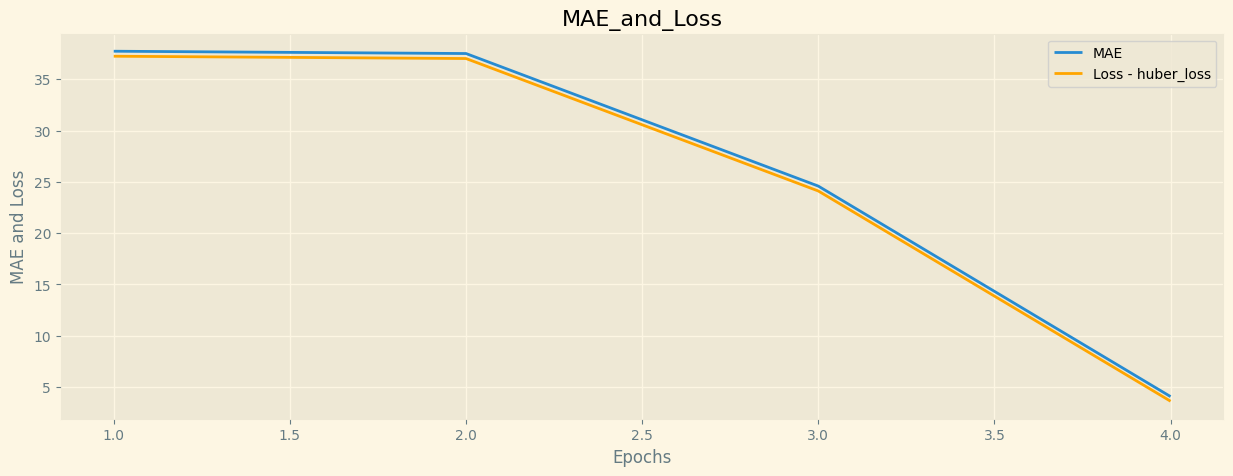

In [3]:
# -----------------------------Model Architecture--------------------------
model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(None, 2)),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1),
        ]
    )

model = TFModelService.name_model(model, config)
log_model_info(config, model, logger)


# -----------------------------Model Training-------------------------------
model.compile(loss=config['model']['loss'], 
            optimizer=config['model']['optimizer'], 
            metrics=['mae','mape'],
            )    

history = model.fit(train_dataset, epochs=config['model']['epochs'])

# Plot MAE and Loss
mae=history.history['mae']
loss=history.history['loss']
zoom = int(len(mae) * config['plots']['loss_zoom'])

V.plot_series(x=range(config['model']['epochs'])[-zoom:],
                y=(mae[-zoom:],loss[-zoom:]),
                model_name=config['model']['name'],
                title='MAE_and_Loss',
                xlabel='Epochs',
                ylabel=f'MAE and Loss',
                legend=['MAE', f'Loss - {config["model"]["loss"]}'],
                show=config['plots']['show'],
            )

In [4]:
# # Save the model
TFModelService.save_model(model=model, logger=logger)    
TFModelService.save_scalers(scalers=scalers_X, model_name=model._name ,logger=logger)


# #------------------------Load the model if necessary--------------------------
# model_scaler_name = 'MSFT_LSTM_W10_SBS5500_B32_E500_P42113_2023_10_09__15_49'
# model = TFModelService.load_model(model_name=model_scaler_name, logger=logger)
# scalers_X = TFModelService.load_scalers(model_name=model_scaler_name, logger=logger)

2023-10-10 21:08:19 - __main__ - INFO - Model saved as MSFT_LSTM_W20_SBS5500_B64_E5_P42113_2023_10_10__21_08.keras
2023-10-10 21:08:19 - __main__ - INFO - Scalers saved: "/workspaces/p7-trading-bot/models_trained/MSFT_LSTM_W20_SBS5500_B64_E5_P42113_2023_10_10__21_08_scalers.pkl"


{'Adj Close': MinMaxScaler(), 'Volume': MinMaxScaler()}
280/280 [==============================] - 2s 5ms/step


2023-10-10 21:08:21.643398: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1004545830146506946
2023-10-10 21:08:21 - src.common.plots - INFO - Plot "Predictions-LSTM.png" saved to "/workspaces/p7-trading-bot/figures/Predictions-LSTM.png"


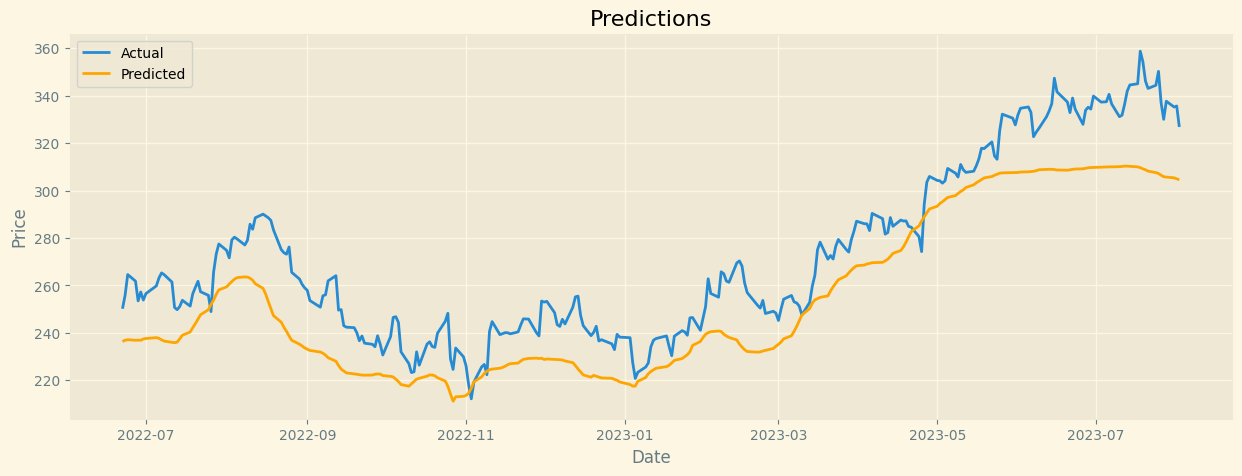

In [5]:
# -----------------------------Predictions-----------------------------------
results = TFModelService.model_forecast(model=model, 
                                        df=df_test_X,
                                        window_size=TFModelService.get_window_size_from_model_name(model._name),
                                        scalers=scalers_X,
                                        verbose=False)

df_test_plot_y = TFModelService.prep_test_df_shape(df_test_y, TFModelService.get_window_size_from_model_name(model._name))

V.plot_series(  x=df_test_plot_y.index,  # as dates
                y=(df_test_plot_y, results),
                model_name=config['model']['name'],
                title='Predictions',
                xlabel='Date',
                ylabel='Price',
                legend=['Actual', 'Predicted'],
                show=config['plots']['show'],)

In [6]:
# -----------------------Calculate Errors----------------------------------
naive_forecast = ErrorCalc.get_naive_forecast(df).loc[df_test_plot_y.index] # Getting same days as results
rmse, mae, mape, mase = ErrorCalc.calc_errors(df_test_plot_y, results, naive_forecast)
ErrorCalc.save_errors_to_table(model._name, {'rmse': rmse, 'mae': mae, 'mape': mape, 'mase': mase})

2023-10-10 21:08:22 - src.models_service.errors - INFO - Test RMSE: $ 20.179
2023-10-10 21:08:22 - src.models_service.errors - INFO - Test MAE : $ 18.075
2023-10-10 21:08:22 - src.models_service.errors - INFO - Test MAPE:   0.066
2023-10-10 21:08:22 - src.models_service.errors - INFO - Test MASE:   4.389
2023-10-10 21:08:22 - src.models_service.errors - INFO - Errors saved to for MSFT_LSTM_W20_SBS5500_B64_E5_P42113_2023_10_10__21_08 model to "logs/models_table.csv" file.
